In [25]:
import torch
import torchvision
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [26]:
%run datasets.ipynb

In [27]:
dataset_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

full_dataset = FathomNetCroppedDataset(
    root='/home/gardar/PycharmProjects/deep-sea-organism-detection/data', 
    classes=['Strongylocentrotidae',
             'Elpidiidae',
             'Isididae',
             'Psolidae',
             'Asteriidae'],
    transforms=dataset_transforms) 


train_size = int(len(full_dataset) * 0.7)
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=4, num_workers=0, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, num_workers=0, shuffle=False)

In [28]:
class_names = full_dataset.classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.Size([4, 3, 224, 224])
torch.Size([4])


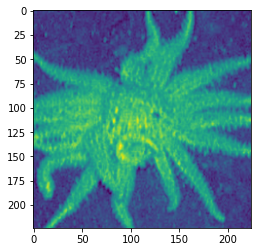

In [29]:
# Get a batch of training data
inputs, labels = next(iter(train_loader))
print(inputs.shape)

print(labels.shape)

plt.imshow(inputs[0,0,:,:])

In [30]:
#This is mostly code from the PyTorch tutorial webpage 
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_loader
                model.train()  # Set model to training mode
            else:
                dataloader = test_loader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
                epoch_loss = running_loss / len(train_dataset)
                epoch_acc = running_corrects.double() / len(train_dataset)
            else:
                epoch_loss = running_loss / len(test_dataset)
                epoch_acc = running_corrects.double() / len(test_dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [31]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [32]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


KeyboardInterrupt: 